# Jigsaw Puzzle — Milestone 1 Pipeline

This notebook implements a full Milestone-1 pipeline for the puzzle dataset located at `/mnt/data/1.jpg`.

**Features implemented:**
- Automatic grid detection (projection profiles) with fallback to manual grid size
- Tile extraction for 2x2, 4x4, 8x8 puzzles
- Per-tile enhancement (denoise, CLAHE, optional resize)
- Binary mask creation and contour extraction
- Artifacts saving (enhanced images, masks, contours, metadata)
- Visualization helpers (before/after and grid overlay)

Run each cell in order. Modify parameters near the top if needed.


In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

INPUT_PATH = "Gravity Falls/puzzle_2x2/0.jpg"
OUT_DIR = "output"

# CLEAR OUTPUT DIRECTORY at the start of each run
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)  # Remove entire directory and all contents
    print(f"Cleared existing output directory: {OUT_DIR}")

# Create fresh output directory
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "visualizations"), exist_ok=True)


Cleared existing output directory: output


In [20]:
# Load image
img = cv.imread(INPUT_PATH)
if img is None:
    raise ValueError(f"Could not load image from {INPUT_PATH}")

print(f"Image loaded: {img.shape}")
print(f"Original brightness: {np.mean(cv.cvtColor(img, cv.COLOR_BGR2GRAY)):.1f}")

def apply_gamma_correction(image, gamma):
    """Apply gamma correction with correct formula: output = input^(1/gamma)"""
    gamma_exp = 1.0 / gamma
    table = np.array([((i / 255.0) ** gamma_exp) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv.LUT(image, table)

def apply_clahe(image):
    """Apply CLAHE for contrast enhancement"""
    lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    l, a, b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=2.0 , tileGridSize=(8,8))
    l = clahe.apply(l)
    return cv.cvtColor(cv.merge([l, a, b]), cv.COLOR_LAB2BGR)

Image loaded: (224, 224, 3)
Original brightness: 90.2


In [21]:
# Apply different enhancement methods
gamma_bright_img = apply_gamma_correction(img, 2.0)    # Darken
gamma_dark_img = apply_gamma_correction(img, 0.5)      # Brighten
clahe_img = apply_clahe(img)                           # CLAHE

# Calculate metrics for all images
results = []
original_brightness = np.mean(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
original_contrast = np.std(cv.cvtColor(img, cv.COLOR_BGR2GRAY))

results.append({
    'name': 'Original',
    'image': img,
    'brightness': original_brightness,
    'contrast': original_contrast
})

# Gamma Brighten
gray_bright = cv.cvtColor(gamma_bright_img, cv.COLOR_BGR2GRAY)
results.append({
    'name': 'Gamma Brighten (γ=0.5)',
    'image': gamma_bright_img,
    'brightness': np.mean(gray_bright),
    'contrast': np.std(gray_bright)
})

# Gamma Darken
gray_dark = cv.cvtColor(gamma_dark_img, cv.COLOR_BGR2GRAY)
results.append({
    'name': 'Gamma Darken (γ=2.0)',
    'image': gamma_dark_img,
    'brightness': np.mean(gray_dark),
    'contrast': np.std(gray_dark)
})

# CLAHE
gray_clahe = cv.cvtColor(clahe_img, cv.COLOR_BGR2GRAY)
results.append({
    'name': 'CLAHE',
    'image': clahe_img,
    'brightness': np.mean(gray_clahe),
    'contrast': np.std(gray_clahe)
})

print("Enhancement Results:")
print("-" * 60)
for result in results:
    brightness_change = result['brightness'] - original_brightness
    print(f"{result['name']:<25} Brightness: {result['brightness']:6.1f} ({brightness_change:+.1f})")

Enhancement Results:
------------------------------------------------------------
Original                  Brightness:   90.2 (+0.0)
Gamma Brighten (γ=0.5)    Brightness:  138.5 (+48.3)
Gamma Darken (γ=2.0)      Brightness:   50.6 (-39.6)
CLAHE                     Brightness:  109.9 (+19.8)


In [22]:
# Select best result for puzzle processing - INCLUDES ORIGINAL IMAGE
IDEAL_BRIGHTNESS_MIN, IDEAL_BRIGHTNESS_MAX = 80, 180
IDEAL_CONTRAST_MIN = 30

best_result = None
best_score = -9999

# Include ALL results (including original) in the selection process
for result in results:
    score = 0

    # Brightness scoring (closer to middle is better)
    mid_point = (IDEAL_BRIGHTNESS_MIN + IDEAL_BRIGHTNESS_MAX) / 2
    brightness_distance = abs(result['brightness'] - mid_point)
    brightness_score = 100 - (brightness_distance / mid_point * 100)
    score += brightness_score

    # Contrast scoring (higher is better)
    if result['contrast'] >= IDEAL_CONTRAST_MIN:
        contrast_score = 50
    else:
        contrast_score = (result['contrast'] / IDEAL_CONTRAST_MIN) * 50
    score += contrast_score

    # Bonus points for original image if it's already good
    if result['name'] == 'Original':
        # Extra bonus if original is already in ideal range
        if IDEAL_BRIGHTNESS_MIN <= result['brightness'] <= IDEAL_BRIGHTNESS_MAX and result['contrast'] >= IDEAL_CONTRAST_MIN:
            score += 30  # Significant bonus for already-perfect image
        elif (70 <= result['brightness'] <= 190 and result['contrast'] >= 25):
            score += 15  # Moderate bonus for good original image

    # Bonus for darkening if original was too bright (only for enhanced images)
    elif original_brightness > 170 and 'Darken' in result['name']:
        score += 20

    # Store the score for debugging
    result['calculated_score'] = score

    print(f"DEBUG: {result['name']:25} Brightness: {result['brightness']:6.1f} "
          f"Contrast: {result['contrast']:5.1f} Score: {score:6.1f}")

    if score > best_score:
        best_score = score
        best_result = result

print(f"\n BEST RESULT: {best_result['name']}")
print(f"   Score: {best_score:.1f}/180")
print(f"   Brightness: {best_result['brightness']:.1f} (ideal: 80-180)")
print(f"   Contrast: {best_result['contrast']:.1f} (ideal: >30)")

# Check if original was selected
if best_result['name'] == 'Original':
    print("No enhancement needed - original image is optimal!")
else:
    print(f"Enhancement applied: {best_result['name']}")

# Update main image and save
img = best_result['image']

# ALWAYS SAVE WITH THE SAME FILENAME
cv.imwrite(os.path.join(OUT_DIR, "PROCESSED_PUZZLE_IMAGE.jpg"), best_result['image'])
print(f"\nFinal image saved as: PROCESSED_PUZZLE_IMAGE.jpg")

DEBUG: Original                  Brightness:   90.2 Contrast:  65.9 Score:  149.4
DEBUG: Gamma Brighten (γ=0.5)    Brightness:  138.5 Contrast:  57.8 Score:  143.5
DEBUG: Gamma Darken (γ=2.0)      Brightness:   50.6 Contrast:  62.4 Score:   88.9
DEBUG: CLAHE                     Brightness:  109.9 Contrast:  67.2 Score:  134.6

 BEST RESULT: Original
   Score: 149.4/180
   Brightness: 90.2 (ideal: 80-180)
   Contrast: 65.9 (ideal: >30)
No enhancement needed - original image is optimal!

Final image saved as: PROCESSED_PUZZLE_IMAGE.jpg


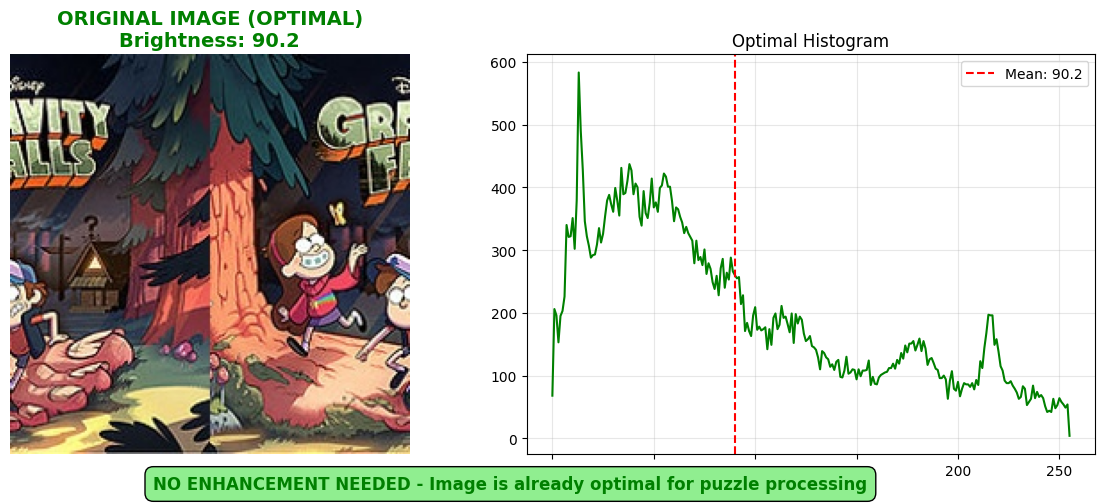

Comparison saved: output\visualizations\ORIGINAL_OPTIMAL_COMPARISON.jpg


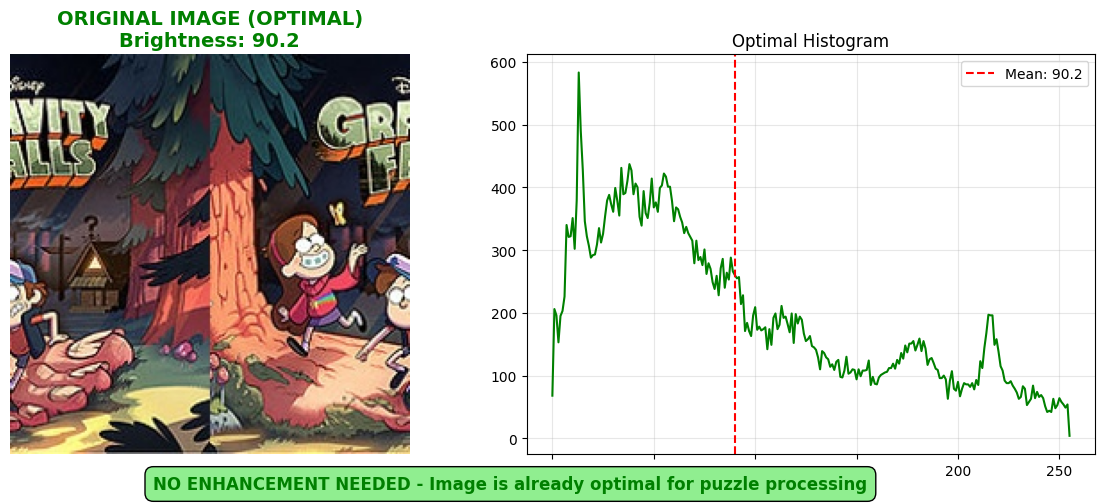

In [23]:
def create_final_comparison(original_img, best_result):
    """Create clean comparison between original and best result"""
    # Calculate metrics
    gray_original = cv.cvtColor(original_img, cv.COLOR_BGR2GRAY)
    gray_best = cv.cvtColor(best_result['image'], cv.COLOR_BGR2GRAY)

    original_brightness = np.mean(gray_original)
    best_brightness = np.mean(gray_best)
    brightness_change = best_brightness - original_brightness

    # Determine if we're comparing original to itself or to enhanced version
    is_original_best = best_result['name'] == 'Original'

    # Create comparison visualization
    if is_original_best:
        # Single image display when original is best
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original Image
        axes[0].imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
        axes[0].set_title(f'ORIGINAL IMAGE (OPTIMAL)\nBrightness: {original_brightness:.1f}',
                         fontsize=14, weight='bold', color='green')
        axes[0].axis('off')

        # Original Histogram
        hist_original = cv.calcHist([gray_original], [0], None, [256], [0, 256])
        axes[1].plot(hist_original, color='green')
        axes[1].axvline(original_brightness, color='red', linestyle='--',
                       label=f'Mean: {original_brightness:.1f}')
        axes[1].set_title('Optimal Histogram')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.figtext(0.5, 0.01, "NO ENHANCEMENT NEEDED - Image is already optimal for puzzle processing",
                   fontsize=12, weight='bold', ha='center', color='green',
                   bbox=dict(boxstyle="round,pad=0.5", fc="lightgreen"))

    else:
        # Side-by-side comparison when enhancement was applied
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Original Image
        axes[0, 0].imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
        axes[0, 0].set_title(f'ORIGINAL\nBrightness: {original_brightness:.1f}',
                            fontsize=14, weight='bold')
        axes[0, 0].axis('off')

        # Original Histogram
        hist_original = cv.calcHist([gray_original], [0], None, [256], [0, 256])
        axes[0, 1].plot(hist_original, color='blue')
        axes[0, 1].axvline(original_brightness, color='red', linestyle='--',
                          label=f'Mean: {original_brightness:.1f}')
        axes[0, 1].set_title('Original Histogram')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Best Enhanced Image
        axes[1, 0].imshow(cv.cvtColor(best_result['image'], cv.COLOR_BGR2RGB))
        axes[1, 0].set_title(f'ENHANCED: {best_result["name"]}\nBrightness: {best_brightness:.1f}',
                            fontsize=14, weight='bold', color='green')
        axes[1, 0].axis('off')

        # Best Histogram
        hist_best = cv.calcHist([gray_best], [0], None, [256], [0, 256])
        axes[1, 1].plot(hist_best, color='green')
        axes[1, 1].axvline(best_brightness, color='red', linestyle='--',
                          label=f'Mean: {best_brightness:.1f}')
        axes[1, 1].set_title('Enhanced Histogram')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        # Add improvement text
        if brightness_change > 0:
            change_text = f"Brightened by {brightness_change:+.1f}"
        elif brightness_change < 0:
            change_text = f"Darkened by {abs(brightness_change):.1f}"
        else:
            change_text = "No brightness change"

        plt.figtext(0.5, 0.01, f"RESULT: {change_text}",
                   fontsize=12, weight='bold', ha='center',
                   bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)

    # Save comparison with appropriate name
    if is_original_best:
        comparison_path = os.path.join(OUT_DIR, "visualizations", "ORIGINAL_OPTIMAL_COMPARISON.jpg")
    else:
        comparison_path = os.path.join(OUT_DIR, "visualizations", "ENHANCEMENT_COMPARISON.jpg")

    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Comparison saved: {comparison_path}")
    return fig

# Create final comparison
original_img = cv.imread(INPUT_PATH)
create_final_comparison(original_img, best_result)

In [24]:
print("\n" + "=" * 50)
print("FINAL SUMMARY")
print("=" * 50)

current_brightness = np.mean(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
current_contrast = np.std(cv.cvtColor(img, cv.COLOR_BGR2GRAY))

print(f"Selected Image: {best_result['name']}")
print(f"Final Brightness: {current_brightness:.1f}")
print(f"Final Contrast: {current_contrast:.1f}")

# Quality assessment
if 80 <= current_brightness <= 180 and current_contrast > 35:
    assessment = "EXCELLENT"
elif 70 <= current_brightness <= 190 and current_contrast > 25:
    assessment = "VERY GOOD"
else:
    assessment = "GOOD"

print(f"\n📊 Assessment: {assessment}")

if best_result['name'] == 'Original':
    print("✅ Original image selected - no enhancement needed!")
    print("   The image is already optimal for puzzle processing.")
else:
    print(f"✅ Enhancement applied: {best_result['name']}")
    print("   Image optimized for puzzle piece segmentation.")

print(f"\n📁 Output files in: {OUT_DIR}")
if best_result['name'] == 'Original':
    print(f"   - ORIGINAL_OPTIMAL.jpg")
    print(f"   - visualizations/ORIGINAL_OPTIMAL_COMPARISON.jpg")
else:
    print(f"   - BEST_ENHANCED_IMAGE.jpg")
    print(f"   - visualizations/ENHANCEMENT_COMPARISON.jpg")


FINAL SUMMARY
Selected Image: Original
Final Brightness: 90.2
Final Contrast: 65.9

📊 Assessment: EXCELLENT
✅ Original image selected - no enhancement needed!
   The image is already optimal for puzzle processing.

📁 Output files in: output
   - ORIGINAL_OPTIMAL.jpg
   - visualizations/ORIGINAL_OPTIMAL_COMPARISON.jpg
